In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Channel model tutorial

This tutorial simulates a re-entrant channel. Channel models provide an ideal opportunity to explore baroclinic instability and show the impact of mesoscale eddies on the large-scale flow. They also provide an excellent opportunity to introduce the Gent-McWilliams eddy parameterisation (pkg/gmredi) and relaxation boundary conditions (pkg/rbcs).

## A function for saving the fields in to MITgcm compatible binary files

In [2]:
def writefield(fname,data):
    import sys
    print ('write to file: '+fname)
    if sys.byteorder == 'little': data.byteswap(True)
    fid = open(fname,"wb")
    data.tofile(fid)
    fid.close()

# Horizontal resolution
The functions are written in terms of real coordinates in km. This logical variable controls the number of grid points to use.
- `False` $\rightarrow$ coarse resolution (50 km)
- `True` $\rightarrow$ eddy resolving (5 km)

In [3]:
eddy_resolving = False

## Generate the vertical grid
Use the hyperbolic tangent method of Stewart et al. (2017) to design an optimal grid. The code below is a lightly modified version of https://github.com/kialstewart/vertical_grid_for_ocean_models

In [4]:
# what is the maximum depth of your ocean (approximately)? in metres?
H = 4e3

# what is the maximum grid spacing (the grid spacing at the deepest point in the ocean)? in meters
dzd = 150.0

# what is the minimum grid spacing (the grid spacing at the ocean surface)? in meters
min_dz = 5.0

def generate_vertical_grid(H, dzd, min_dz, depfac=1.03,
                            save_files=False,
                            super_grid_filename="ocean_vertical_grid_for_MOM5.nc",
                            regular_grid_filename="ocean_vertical_grid.nc"):
    """
    Generate a vertical grid.
    
    build a vertical grid for ocean models
    the functional form of the vertical grid is hyperbolic tangent
    
    
    Parameter:
    - H: Maximum depth of your ocean in metres
    - dzd: Maximum grid spacing in metres
    - min_dz: Minimum grid spacing in metres
    - deepfac: How sharp/gentle would you like the hyperbolic tangent?
        (<1 is sharp, 1 is neutral, >1 is gentle) This is used to "tune" the number of
        levels to an acceptable amount
    
    this is scripted for MOM5 which uses the "super grid"
    the "super grid" is a netcdf variable called "zeta"
    which is a vector of the depths at the top, middle and bottom of each cell
    this vector is of length 2N-1 where N is the number of z levels in the model

    this also builds a regular grid
    the regular grid is written to netcdf file as a variable called "v_grid"
    v_grid is a vector of the depths at the top and bottom of each cell
    this vector is of length N-1 where N is the number of z levels in the model

    Adapted from code written by Kial Stewart
    this function relates to the Ocean Modelling paper "Vertical resolution of
    baroclinic modes in global ocean models" by Stewart et al.

    """

    import netCDF4 as nc
    import numpy as np

    # define the functional form of the vertical grid
    epsilon = 0.001 # this is a small number needed to begin the iteration
    def f_all(kk):
        return np.tanh(np.pi*((kk)/(H*depfac)))*(dzd)+epsilon
    # the function is {tanh(pi*m/H)*dz_max + epsilon}, which is epsilon at the surface and dz_max at H

    # make the first two entries of the initial grid; these will be 0 and epsilon for both z and dz
    delta_z = [0,epsilon*1.0]
    prop_z = [0,epsilon*1.0]

    # this is where the magic happens: an iterative process that takes a step from
    # the current end (deepest point) of the grid along the function to find the next point
    while prop_z[-1]+delta_z[-1] < 1.2*H:
        aa = np.linspace(1.0,1.5,10000)
        bb = np.zeros([len(aa)])
        loopkill = 1.0
        ii = 0
        while loopkill > 0:
            bb[ii] = (f_all(prop_z[-1]+(delta_z[-1]*aa[ii])))-(delta_z[-1]*aa[ii])
            loopkill = bb[ii]
            ii += 1
        aa_bb = np.polyfit(aa[:ii-1],bb[:ii-1],1)
        dznew = (delta_z[-1]*(np.abs(aa_bb[1]/aa_bb[0])))
        delta_z = np.append(delta_z,dznew)
        prop_z = np.append(prop_z,(prop_z[-1]+delta_z[-1]))

    # now that we have an initial grid that follows the desired functional form we need to relocate
    # it vertically so that the grid spacing at the surface is min_dz
    new_surf = np.max(np.where(delta_z<min_dz)) # find where the initial grid is min_dz (the surface resolution)
    real_prop_z = prop_z[new_surf:]-prop_z[new_surf] # make a new grid that shifts the initial grid vertically
    real_delta_z = delta_z[new_surf:] # make a new dz for this new grid
    real_prop_z = real_prop_z[np.where(real_prop_z<H)] # cut the new grid off at desired depth, H
    real_delta_z = real_delta_z[np.where(real_prop_z<H)] # and the new dz too

    ################
    # for MOM we need the "super grid"
    ################

    super_vgrid = np.zeros([(2*(len(real_prop_z)-1))+1])

    for zz in np.arange(len(real_prop_z)):
        super_vgrid[zz*2] = real_prop_z[zz]

    for zz in np.arange(len(real_prop_z)-1):
        super_vgrid[1+(zz*2)] = real_prop_z[zz+1] - ((real_prop_z[zz+1] - real_prop_z[zz])/2)

    if save_files:
        eddyfile = nc.Dataset('./'+super_grid_filename, 'w', format='NETCDF4')
        eddyfile.createDimension('nzv', len(super_vgrid))
        zeta = eddyfile.createVariable('zeta','f8',('nzv',))
        zeta.units = 'meters'
        zeta.standard_name = 'vertical_grid_vertex'
        zeta.long_name = 'vertical_super_grid_for_MOM5:_depth_at_the_top_and_middle_and_bottom_of_each_cell'
        zeta.author = 'Kial Stewart'
        eddyfile.variables['zeta'][:] = super_vgrid
        eddyfile.close()

        eddyfile = nc.Dataset('./'+regular_grid_filename, 'w', format='NETCDF4')
        eddyfile.createDimension('nzv', len(real_prop_z))
        v_grid = eddyfile.createVariable('v_grid','f8',('nzv',))
        v_grid.units = 'meters'
        v_grid.standard_name = 'vertical_grid'
        v_grid.long_name = 'vertical_grid_depth_at_top_and_bottom_of_each_cell'
        v_grid.author = 'Kial Stewart'
        eddyfile.variables['v_grid'][:] = real_prop_z
        eddyfile.close()

    print ("SUCCESS!! You now have a vertical grid of ", len(real_prop_z)-1, 
           " levels with grid spacing ranging from ", real_delta_z[0]," to ",
           real_delta_z[-1])
    if save_files:
        print(" written to files ",super_grid_filename," and ",regular_grid_filename)
        
    return real_prop_z, real_delta_z


In [5]:
zp1, dz = generate_vertical_grid(H, dzd, min_dz)
# first element of dz shouldn't be there
dz = np.delete(dz, 0)

nz = dz.shape[0]

# depth of cell centres
z = np.zeros_like(dz)
z[0] = dz[0]/2
for k in range(1,nz):
    z[k] = z[k-1] + dz[k-1]/2 + dz[k]/2

SUCCESS!! You now have a vertical grid of  49  levels with grid spacing ranging from  4.860299646114549  to  149.35458582006274


Copy these values for dz into the `data` file.

In [6]:
dz

array([  5.48716549,   6.19462098,   6.99291201,   7.89353689,
         8.90937723,  10.05483267,  11.34595414,  12.80056778,
        14.43837763,  16.28102917,  18.35210877,  20.67704362,
        23.28285446,  26.1976981 ,  29.45012046,  33.06792588,
        37.07656002,  41.496912  ,  46.34247864,  51.61592052,
        57.30518684,  63.37960847,  69.78661289,  76.44996107,
        83.27047568,  90.13003112,  96.89898027, 103.44631852,
       109.65099217, 115.4122275 , 120.65692923, 125.34295968,
       129.45821977, 133.01641219, 136.05088105, 138.60793752,
       140.74074276, 142.50436556, 143.95220912, 145.133724  ,
       146.09317287, 146.86917206, 147.49475454, 147.99774783,
       148.40131516, 148.72455653, 148.98310489, 149.18968055,
       149.35458582])

Text(0.5,0,'Vertical grid spacing (m)')

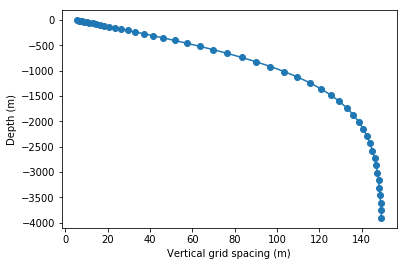

In [7]:
plt.plot(dz, -z, '-o')
plt.ylabel('Depth (m)')
plt.xlabel('Vertical grid spacing (m)')

In [8]:
dz.sum()

3982.2608621419236

## Horizontal grid

We will construct two horizontal grids. We will use a coarse resolution grid (50 km) and an eddy resolving grid (5 km). 

In [9]:
Lx = 1e6
Ly = 2e6

### Coarse resolution grid

In [10]:
nx = 20
ny = 40

x = np.linspace(0.5*Lx/nx, Lx-0.5*Lx/nx, num=nx)
y = np.linspace(0.5*Ly/ny, Ly-0.5*Ly/ny, num=ny)

### Eddy resolving grid

In [11]:
if eddy_resolving:
    nx = 200
    ny = 400

    x = np.linspace(0.5*Lx/nx, Lx-0.5*Lx/nx, num=nx)
    y = np.linspace(0.5*Ly/ny, Ly-0.5*Ly/ny, num=ny)
else:
    pass

## Bathymetry
Generate a bathymetry file with a wall at the southern boundary and a number of sea mounts.

In [12]:
np.random.seed(42)

bathy = np.zeros((ny, nx), dtype='float64') - dz.sum()

X, Y = np.meshgrid(x,y)
    
N_mountains = 38
Hmax_mountains = 1.5e3
Rmax_mountains = 2e5

x0 = Lx*np.random.uniform(0.25,0.75,N_mountains)
y0 = Ly* np.random.uniform(0,1,N_mountains)
h = Hmax_mountains*np.random.uniform(0,1,N_mountains)
r = Rmax_mountains*np.random.uniform(0,1,N_mountains)

for n in range(N_mountains):
    
    mountain = h[n]*np.exp(-((X-x0[n])**2 + (Y-y0[n])**2)/r[n]**2 )
#     print(mountain.max())
    bathy = bathy + mountain
    
# wall at southern boundary
bathy[0,:] = 0

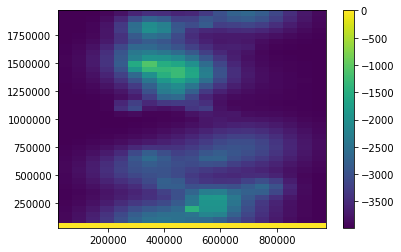

In [13]:
plt.pcolormesh(X, Y, bathy)
plt.colorbar()

In [14]:
print(bathy[1:,:].mean())
print(bathy[1:,:].max())

-3468.225267194459
-1101.8858934941222


In [15]:
writefield('../input/bathy.bin', bathy)

write to file: ../input/bathy.bin


## Temperature relaxation fields
For the SST, use a linear temperature profile, which goes from -2$^{\circ}$C at the southern border to 10$^{\circ}$C at the northern border

For the norhtern sponge region, use the SST value and an exponential in z.

Vertical structure is given by 
$$
T(z) = (T_{max} - T_{min}) \frac{exp(z/h) - exp(-H/h)}{1 - exp(-H/h)} + T_{min}
$$

In [16]:
# Depth of the ocean
H = dz.sum()
# Vertical scale height
h = 500
# Temperature limits
Tmin = -2
Tmax = 10

In [17]:
def generate_T_surf(Tmin, Tmax, x, y, Ly):
    
    X, Y = np.meshgrid(x,y)
    
    T = Tmin + (Tmax-Tmin)*Y/Ly
    
    return T
    

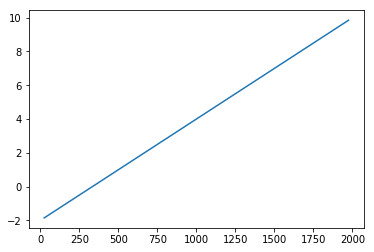

In [18]:
T_surf = generate_T_surf(Tmin, Tmax, x, y, Ly)
plt.plot(y/1e3, T_surf[:,0])

## Three dimensional temperature field

In [19]:
T_3D = np.zeros((nz,ny,nx))

for j in range(ny):
    for i in range(nx):
        T_3D[:,j,i] = (T_surf[j,i] - Tmin)*(np.exp(-z/h) - np.exp(-H/h))/(1-np.exp(-H/h)) + Tmin

Text(0,0.5,'Depth (m)')

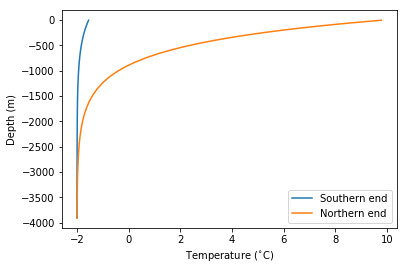

In [20]:
plt.plot(T_3D[:,1,1], -z, label='Southern end')
plt.plot(T_3D[:,-1,1], -z, label='Northern end')
plt.legend()
plt.xlabel('Temperature ($^{\circ}$C)')
plt.ylabel('Depth (m)')

In [21]:
writefield('../input/T_surf.bin', T_surf)
writefield('../input/temperature.bin', T_3D)

write to file: ../input/T_surf.bin
write to file: ../input/temperature.bin


## Temperature relaxation mask
Should be 1 along the norther boundary. Transition to 0 over about 100 km going north to south.

In [22]:
T_relax_mask = np.zeros_like(T_3D)


for k in range(nz):
    T_relax_mask[k,:,:] = Y/1e5 - 19

T_relax_mask = np.maximum(T_relax_mask, 0)

T_relax_mask[:,-1,:] = 1

Text(0,0.5,'Temperature relaxation mask \n (>0 means relaxation)')

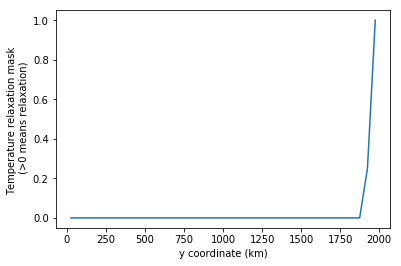

In [23]:
plt.plot(y/1e3, T_relax_mask[1,:,0])
plt.xlabel('y coordinate (km)')
plt.ylabel('Temperature relaxation mask \n (>0 means relaxation)')

In [24]:
writefield('../input/T_relax_mask.bin', T_relax_mask)


write to file: ../input/T_relax_mask.bin


## Zonal wind

In [25]:
def generate_zonal_wind(tau_min, tau_max, x, y, Ly):
    
    tau_max = tau_max - 0.5*tau_min
    
    X, Y = np.meshgrid(x,y)
    
    tau =  tau_max*np.sin((Y)*np.pi/(Ly))**2 + tau_min - tau_min*Y/Ly
    
    return tau

In [26]:
zonal_wind = generate_zonal_wind(-0.1, 0.2, x, y, Ly)

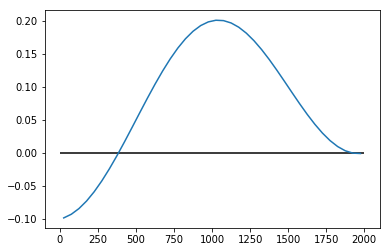

In [27]:
plt.plot(y/1e3, zonal_wind[:,0])
plt.hlines(0, 0, 2e3)

In [28]:
writefield('../input/zonal_wind.bin', zonal_wind)


write to file: ../input/zonal_wind.bin
